In [1]:
import os
import contextlib
import pickle
#data
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#audio
import wave
import librosa
import librosa.display
#train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale
from sklearn.model_selection import KFold
import time
sns.set_theme()
path = "./"

Instructions for updating:
non-resource variables are not supported in the long term


# lista de audios

In [2]:
data = []
i = 0
for root, dirs, files in os.walk(path, topdown=False):
    for filename in files:
        if filename[-4:] == ".wav":
            fname = os.path.join(root, filename)
            with contextlib.closing(wave.open(fname,'r')) as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duration = frames / float(rate)
                data.append([root[2:], filename, duration, rate, frames])

In [3]:
df = pd.DataFrame(data=data, columns=["class", "url", "duration", "rate", "frames"])

In [4]:
df

,class,url,duration,rate,frames
0,coughing,2AV8_4_1_0_44_0_0_0.wav,2.140000,16000,34240
1,coughing,2AV8_4_9_0_44_0_0_0.wav,3.190062,16000,51041
2,coughing,5MSY_4_4_0_30_0_0_0.wav,2.500000,16000,40000
3,coughing,60GO_4_14_0_36_0_0_0.wav,2.390062,16000,38241
4,coughing,79S3_4_3_1_37_0_0_0.wav,2.930063,16000,46881
...,...,...,...,...,...
722,yawning,QHOC_5_14_0_23_0_0_0.wav,2.120000,16000,33920
723,yawning,QHOC_5_2_0_23_0_0_0.wav,2.040000,16000,32640
724,yawning,QHOC_5_4_0_23_0_0_0.wav,2.040000,16000,32640
725,yawning,QHOC_5_7_0_23_0_0_0.wav,2.390062,16000,38241


# cargar audio

In [5]:
sample_num=1
class_ = df.loc[sample_num,['class']].values[0]
url = df.loc[sample_num,['url']].values[0]
filename= f"./{class_}/{url}" #get the filename
print(filename)

./coughing/2AV8_4_9_0_44_0_0_0.wav


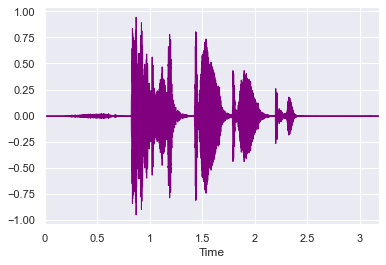

In [6]:
y, sr = librosa.load(filename, sr=16000)
librosa.display.waveplot(y, sr=sr, x_axis='time', color='purple',offset=0.0)

In [7]:
y.shape

(51041,)

In [8]:
sr

16000

# Extraer caracteristicas

In [9]:
audio_length = 6
sampling_rate = 16000
step = 512
n_features = 20
rnn_sizes = [128, 128]
learning_rate = 0.001
load = False
export_dir = './'
load_model_name = 'mfcc_cross'
model_name = 'mfcc_cross'
nb_epochs = 2000
batch_size = 64
display_step = 50
test_step = 200

time_steps_t = audio_length * sampling_rate // 512
time_steps_t

187

In [10]:
mfcc  = librosa.feature.mfcc(y, sr=sr, n_mfcc=n_features).T

In [11]:
time_steps,_ = mfcc.shape

In [12]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, scale

In [13]:
mfcc = scale(mfcc, axis=0)

In [14]:
mfcc.shape

(100, 20)

In [15]:
pad = time_steps_t - time_steps % time_steps_t

In [16]:
pad

87

In [17]:
# pad con ceros para tener el mismo time_steps
if pad < time_steps_t // 3 or time_steps // time_steps_t == 0:
    mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant', constant_values=(0, 0))
    mfcc = mfcc.reshape(time_steps // time_steps_t + 1, time_steps_t, n_features)

# eliminar la última parte si es demasiado corta
else:
    mfcc = mfcc[:time_steps // time_steps_t * time_steps_t, :]
    mfcc = mfcc.reshape(time_steps // time_steps_t, time_steps_t, n_features)

In [18]:
mfcc.shape

(1, 187, 20)

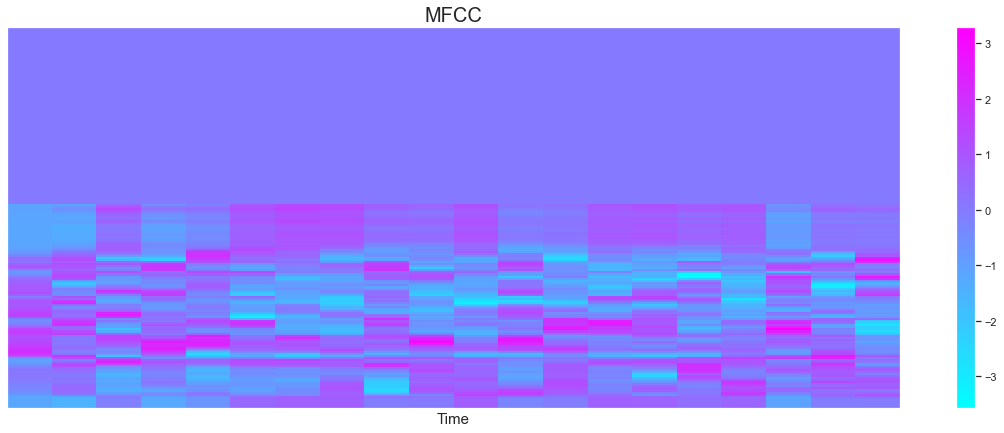

In [19]:
fig, ax = plt.subplots(figsize=(20,7))

librosa.display.specshow(mfcc[0,:,:],sr=sr, cmap='cool')

ax.set_xlabel('Time', fontsize=15)

ax.set_title('MFCC', size=20)

plt.colorbar()

plt.show()

# train_test_split

In [20]:
enc = LabelEncoder()
enc.fit(df[["class"]])
n_classes = len(enc.classes_)

X = df.index.values
Y = enc.transform(df[["class"]])

enc_hot = OneHotEncoder()
enc_hot.fit(Y.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=123, stratify=Y)

In [21]:
Y_test

array([ 5,  7,  6,  1,  5,  7,  6, 14, 10,  4,  8, 12,  7,  0,  2, 14,  0,
        3,  9,  7,  3,  4,  0,  2, 10,  7, 11, 15,  1, 10, 15,  9, 14,  6,
       11,  9,  5,  3,  5,  1,  4, 12,  7,  7,  8,  6, 13,  3, 14, 15, 14,
        8,  4, 11, 13, 12,  4, 10, 10, 15,  3,  3, 15,  2, 11,  8, 13,  7,
       13,  9,  0, 11, 10, 12, 13, 15,  7, 10,  9,  3, 13,  0,  4, 11,  2,
       10,  8,  2,  4,  6,  0,  6,  2, 10,  3, 15,  9,  6,  8,  5,  6,  0,
        4, 12, 15,  6, 14,  5,  9, 10,  1,  3, 12, 15,  3, 12,  5,  9,  5,
       13,  1, 11,  5, 14,  8, 11,  8, 10, 11, 13,  0,  4,  0,  3,  4,  9,
       13,  8, 13, 12,  9, 15, 13,  5,  8, 14,  8,  8, 14,  6,  9, 13,  6,
        0, 12,  3, 12,  8, 15,  4, 11,  3,  0, 15,  5, 13,  7, 14, 10,  7,
       11, 13,  0, 10,  9, 14, 12, 14,  6,  1,  3,  9])

In [22]:
X_test

array([236, 310, 276,  65, 241, 326, 268, 675, 472, 178, 335, 567, 292,
        38,  93, 677,  40, 152, 416, 291, 108, 191,  19,  92, 456, 308,
       533, 684,  56, 445, 688, 406, 656, 271, 508, 417, 221, 122, 233,
        68, 160, 555, 329, 330, 352, 288, 586, 134, 637, 716, 661, 337,
       166, 507, 587, 557, 167, 455, 439, 702, 148, 116, 707,  98, 491,
       369, 623, 313, 626, 430,  22, 519, 466, 535, 617, 706, 317, 446,
       407, 118, 631,  42, 196, 509,  75, 464, 342,  91, 165, 278,   2,
       248,  86, 459, 109, 709, 400, 275, 373, 219, 261,   9, 159, 568,
       682, 249, 667, 212, 413, 476,  62, 140, 547, 692, 137, 556, 223,
       392, 240, 594,  54, 496, 201, 673, 349, 514, 367, 454, 512, 614,
        17, 154,  33, 105, 163, 399, 583, 381, 629, 543, 418, 723, 605,
       208, 380, 649, 385, 372, 634, 246, 410, 582, 244,  28, 560, 126,
       575, 377, 680, 183, 513, 111,  32, 703, 225, 584, 316, 632, 463,
       301, 495, 610,  34, 488, 433, 640, 552, 651, 250,  61, 11

In [23]:
df.loc[X_test]

,class,url,duration,rate,frames
236,moaning,X2OC_14_8_0_23_0_0_0.wav,2.661625,16000,42586
310,panting,HEVI_10_5_0_39_0_0_0.wav,3.130063,16000,50081
276,nose-blowing,TKSZ_3_12_1_30_0_0_0.wav,2.470063,16000,39521
65,crying,KW7F_11_7_0_23_0_0_0.wav,5.260000,16000,84160
241,moaning,ZXH4_14_2_1_27_0_0_0.wav,2.500000,16000,40000
...,...,...,...,...,...
651,tongue-clicking,FNGU_2_2_1_18_0_0_0.wav,3.750062,16000,60001
250,nose-blowing,7K3Y_3_15_0_40_0_0_0.wav,3.072563,16000,49161
61,crying,G5T1_11_6_0_30_0_0_0.wav,5.960000,16000,95360
113,lip-popping,612M_8_10_0_18_0_0_0.wav,2.000000,16000,32000


# Get features 

In [24]:
audio_length = 6
sampling_rate = 16000
step = 512
n_features = 20
time_steps_t = audio_length * sampling_rate // 512
time_steps_t

def get_features(df_in, type_train_test):
    mfccs = []
    fnames = []
    labels = []
    indexs = []
    for index, row in df_in.iterrows():
        print(index)
        label = df.loc[index,['class']].values[0]
        url = df.loc[index,['url']].values[0]
        filename= f"./{label}/{url}"
             
        y, sr = librosa.load(filename, sr=16000)
        
        mfcc  = librosa.feature.mfcc(y, sr=sr, n_mfcc=n_features).T
        time_steps,_ = mfcc.shape
        mfcc = scale(mfcc, axis=0)
        pad = time_steps_t - time_steps % time_steps_t
        
        # pad con ceros para tener el mismo time_steps
        if pad < time_steps_t // 3 or time_steps // time_steps_t == 0:
            mfcc = np.pad(mfcc, ((0, pad), (0, 0)), mode='constant', constant_values=(0, 0))
            mfcc = mfcc.reshape(time_steps // time_steps_t + 1, time_steps_t, n_features)

        # eliminar la última parte si es demasiado corta
        else:
            mfcc = mfcc[:time_steps // time_steps_t * time_steps_t, :]
            mfcc = mfcc.reshape(time_steps // time_steps_t, time_steps_t, n_features)
        
        for i in range(mfcc.shape[0]):
            mfccs.append(mfcc[i, :, :])
            fnames.append(filename)
            labels.append(label)
            indexs.append(index)
            
    df_mfcc = pd.DataFrame({
        'fname': fnames,
        'label': labels,
    }, index=indexs)
    df_mfcc.to_csv(f'mfcc_{type_train_test}.csv')
    with open(f'mfcc_{type_train_test}.p', 'wb') as fp:
        pickle.dump(np.array(mfccs), fp)
    
get_features(df.loc[X_train], "train")
get_features(df.loc[X_test], "Test")

14
474
686
198
237
516
51
44
572
157
616
123
315
218
360
331
376
408
216
158
325
355
620
280
180
368
193
498
120
699
404
679
524
129
479
153
327
365
53
668
453
592
691
294
666
518
527
344
181
82
630
155
485
375
143
494
87
657
434
370
58
309
83
286
517
203
252
144
558
210
311
189
596
256
597
441
347
7
306
386
662
364
132
213
226
12
530
258
685
565
655
678
660
110
687
390
90
395
545
641
142
48
603
11
499
451
182
469
320
522
150
607
437
77
721
24
222
562
627
378
94
689
573
149
384
671
697
611
645
604
264
636
282
171
541
102
652
701
431
232
257
209
106
693
371
619
725
448
501
131
319
47
419
290
39
635
322
179
80
262
653
95
36
298
602
529
432
608
184
504
719
207
192
440
227
389
639
387
127
297
444
638
470
650
487
523
234
84
147
211
525
403
492
339
477
115
676
502
185
285
72
398
363
130
579
299
5
27
287
279
506
263
698
303
428
480
151
69
548
539
391
202
526
55
711
350
695
312
482
267
503
169
625
564
195
550
414
52
478
450
458
138
172
328
566
269
272
265
176
170
67
591
609
429
4
442
379
345
5

# Train

In [25]:
def last_relevant(output, length):
        """
        Return the last relevant output of the LSTM cell, by removing the
        trailing zeros (!! Raise an error it the array is full of zeros)
        From https://danijar.com/variable-sequence-lengths-in-tensorflow/
        """
        batch_size = tf.shape(output)[0]
        max_length = tf.shape(output)[1]
        out_size = int(output.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(output, [-1, out_size])
        relevant = tf.gather(flat, index)
        return relevant

In [26]:
def length(sequence):
        """
        From https://danijar.com/variable-sequence-lengths-in-tensorflow/
        """
        used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
        length = tf.reduce_sum(used, 1)
        length = tf.cast(length, tf.int32)
        return length

In [27]:
def build_rnn(x, keep_prob):
    """
    Build the network
    """
    layer = {
        'weight': tf.Variable(tf.truncated_normal([rnn_sizes[-1], n_classes], stddev=0.01)),
        'bias': tf.Variable(tf.constant(0.1, shape=[n_classes]))
    }
    lstm_cells = [rnn_cell.LSTMCell(rnn_s) for rnn_s in rnn_sizes]
    drop_cells = [tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob) for lstm in lstm_cells]

    lstm = rnn_cell.MultiRNNCell(drop_cells)
    output, state = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32, sequence_length=length(x))
    last = last_relevant(output, length(x))

    return tf.nn.softmax(tf.tensordot(last, layer['weight'], [[1], [0]]) + layer['bias'])

In [ ]:
with open('mfcc_train.p', 'rb') as fp:
    X = pickle.load(fp)
    
df_mfcc = pd.read_csv('mfcc_train.csv')
label = enc_hot.transform(enc.transform(df_mfcc.label).reshape(-1, 1)).toarray()

kf = KFold(n_splits=5, shuffle=True)

for i, index in enumerate(kf.split(X)):
    train_index, test_index = index
    X_train = X[train_index, :, :]
    X_test = X[test_index, :, :]
    
    y_train = label[train_index]
    y_test = label[test_index]
    
    tf.reset_default_graph()
    
    x = tf.placeholder("float", [None, time_steps_t, n_features])
    y = tf.placeholder("float", [None, n_classes])
    keep_prob = tf.placeholder("float", name='keep_prob')
    
    prediction = build_rnn(x, keep_prob)
    
    # Define loss and optimizer
    loss_f = -tf.reduce_sum(y * tf.log(prediction + 1e-10))
    optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss_f)
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()
    with tf.Session() as session:
        saver = tf.train.Saver()
        if load:
            saver.restore(session, export_dir + load_model_name + '{}'.format(i))
        else:
            session.run(init)

        t0 = time.time()
        for epoch in range(nb_epochs):
            start = epoch * batch_size % (len(y_train) - batch_size)
            batch_x = X_train[start:start + batch_size, :, :]
            batch_y = y_train[start:start + batch_size]

            _, c = session.run([optimizer, loss_f], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

            if epoch % display_step == 0:
                # Calculate batch accuracy
                acc = session.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
                # Calculate batch loss
                loss = session.run(loss_f, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})

                print("Fold " + str(i) + ", Iter " + str(epoch) + " / " + str(
                    nb_epochs) + ", Minibatch Loss= " +
                      "{:.6f}".format(loss) + ", Training Accuracy= " +
                      "{:.5f}".format(acc))

                print('{} epochs time: {}'.format(display_step, time.time() - t0))
                t0 = time.time()
            if epoch % test_step == 0:
                print('Test accuracy: ', 
                      round(session.run(accuracy, feed_dict={x: X_test, y: y_test, keep_prob: 1}), 3))

        saver.save(session, export_dir + model_name + '{}'.format(i))

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Fold 0, Iter 0 / 2000, Minibatch Loss= 177.382446, Training Accuracy= 0.07812
50 epochs time: 1.923008918762207
Test accuracy:  0.055
Fold 0, Iter 50 / 2000, Minibatch Loss= 166.302261, Training Accuracy= 0.34375
50 epochs time: 31.421000719070435
Fold 0, Iter 100 / 2000, Minibatch Loss= 111.998123, Training Accuracy= 0.51562
50 epochs time: 31.93003010749817
Fold 0, Iter 150 / 2000, Minibatch Loss= 85.282082, Training Accuracy= 0.67188
50 epochs time: 30.924002647399902
Fold 0, Iter 200 / 2000, Minibatch Loss= 54.711494, Training Accuracy= 0.78125
50 epochs time: 31.30696964263916
Test accuracy:  0.413
Fold 0, Iter 250 / 2000, Minibatch Loss= 43.991783, Train

# Test

In [ ]:
def top_3(predictions, return_string=True):
    top_labels = np.argsort(predictions)
    top_labels = top_labels[::-1]
    top3_labels = top_labels[:1]

    if return_string:
        top3_labels = " ".join([enc.inverse_transform(el) for el in top3_labels])
    return top3_labels

In [ ]:
with open('mfcc_test.p', 'rb') as fp:
    X = pickle.load(fp)

df_mfcc = pd.read_csv('mfcc_test.csv')
predictions = np.zeros((5, len(pd.unique(df_mfcc.fname)), n_classes))

In [ ]:
for j in range(5):
    tf.reset_default_graph()
    x = tf.placeholder("float", [None, time_steps_t, n_features])
    keep_prob = tf.placeholder("float", name='keep_prob')

    prediction = build_rnn(x, keep_prob)
    
    with tf.Session() as session:
        saver = tf.train.Saver()
        saver.restore(session, export_dir + model_name + '{}'.format(j))
        unique = pd.unique(df_mfcc.fname)
        for i in range(len(pd.unique(df_mfcc.fname))):
            idxs = df_mfcc.fname[df_mfcc.fname == unique[i]].index.tolist()

            batch = X[idxs, :, :]
            if batch.sum() == 0:
                batch = np.ones_like(batch)

            pred = session.run(prediction, feed_dict={x: np.array(batch), keep_prob: 1})

            predictions[j, i, :] = pred.mean(axis=0)
    print("Network {} done ! ".format(j))

unique = pd.unique(df_mfcc.fname)

predictions = predictions.mean(axis=0)

In [ ]:
results = {'label': [], 'fname': []}
indexs = []
for i in range(len(pd.unique(df_mfcc.fname))):
    top3_labels = top_3(predictions[i, :], return_string=False)
    results['label'].append(enc.inverse_transform(top3_labels)[0])
    results['fname'].append(unique[i])
    indexs.append(i)
    print('Label for {}: {}'.format(i, enc.inverse_transform(top3_labels)[0]))

df = pd.DataFrame(results, index=indexs)
print(df.head())
df.to_csv("./output-{}.csv".format(model_name), index=False)

In [ ]:
df

In [ ]:
indexs

# Evaluación

In [ ]:
df_y_test = pd.read_csv('mfcc_test.csv',index_col=0)
df_y_test["label-encode"] = enc.transform(df_y_test.label)

df_y_predict = pd.read_csv('output-mfcc_cross.csv')
df_y_predict["label-encode"] = enc.transform(df_y_test.label)

In [ ]:
df_y_test.head()

In [ ]:
df_y_predict.head()